Here we create the database from files and prepare it for neural net

This is to keep an example of use of pyedflib for reading the registers

In [73]:
from __future__ import division
import numpy as np
import pyedflib
import matplotlib.pyplot as plt
%matplotlib inline

f = pyedflib.EdfReader("ssdata/register/ADGU101504.rec")
print(f)

# Show what signals are in there
signal_labels = f.getSignalLabels()
print("signal_labels:", signal_labels)

# Get signal from channel 1 only
signal_1 = f.readSignal(1)
# Get sampling frequency
fs_1 = f.getSampleFrequency(1)

# Close reader
f._close()
del f

# Show numbers
print(n_total)
print(fs_1)

signal_labels: ['F4-C4', 'C4-O2', 'F3-C3', 'C3-O1', 'C4-C3', 'MOR', 'EMG', 'MOV SUP', 'MOV INF', 'ECG', 'RESP NASAL', 'RESP ABD', 'T`', 'PULSO', 'SAO2', 'POSICION', 'RONQUIDOS']
6936200
200


In [20]:
marks_example = "ssdata/label/marks/FixedSS_ADGU101504.txt"
states_example = "ssdata/label/states/StagesOnly_ADGU101504.txt"

# Format is 1:SQ4  2:SQ3  3:SQ2  4:SQ1  5:REM  6:WA
states = np.loadtxt(states_example, dtype='i', delimiter=' ')
#print(states[0])

# First two are start and end for mark. Last two are validity and channel
marks_file = np.loadtxt(marks_example, dtype='i', delimiter=' ')
#print(marks_file[0, :])

#print(marks_file.shape)

#print(marks_file[marks_file[:, 5] == 1, :].shape)

#
path_marks_file = marks_example
marks_file = np.loadtxt(path_marks_file, dtype='i', delimiter=' ')
print(marks_file.shape)
marks_and_validity = marks_file[marks_file[:, 5] == 1][:, [0,1]]
print(marks_and_validity.shape)

(2672, 6)
(2672, 2)


In [1]:
# Imports

from __future__ import division
import numpy as np
import pyedflib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Settings

all_names = [
    'ADGU101504',
    'ALUR012904',
    'BECA011405',
    'BRCA062405',
    'BRLO041102',
    'BTOL083105',
    'BTOL090105',
    'CAPO092605',
    'CRCA020205',
    'ESCI031905',
    'TAGO061203']

path_rec = "ssdata/register/"
rec_postamble = ".rec"

path_marks = "ssdata/label/marks/"
marks_preamble = "FixedSS_"
marks_postamble = ".txt"

path_states = "ssdata/label/states/"
states_preamble = "StagesOnly_"
states_postamble = ".txt"

params = {
    'channel': 1,           # Channel to be used
    'dur_epoch': 30        # Time of window page [s]
    # 'dur_min_ss': 0.3,      # Min SS duration [s]
    # 'dur_max_ss': 3.0       # Max SS duration [s]
}

In [23]:
# Read everything


def read_eeg(path_edf_file, channel):
    file = pyedflib.EdfReader(path_edf_file)
    signal = file.readSignal(channel)
    fs = file.getSampleFrequency(channel)
    file._close()
    del file
    return signal, fs


def read_marks(path_marks_file, channel):
    marks_file = np.loadtxt(path_marks_file, dtype='i', delimiter=' ')
    marks = marks_file[marks_file[:, 5] == channel][:, [0, 1]]
    validity = marks_file[marks_file[:, 5] == channel][:, [4]]
    return marks, validity


def read_states(path_states_file):
    states = np.loadtxt(path_states_file, dtype='i', delimiter=' ')
    # Source format is 1:SQ4  2:SQ3  3:SQ2  4:SQ1  5:REM  6:WA
    # We enforce the fusion of SQ3 and SQ4 in one single stage
    # So now 2:N3  3:N2  4:N1  5:R  6:W
    states[states == 1] = 2
    return states


signal_list = []
marks_list = []
validity_list = []
states_list = []
for i in range(len(all_names)):
    # Read EEG Signal
    path_edf_file = path_rec + all_names[i] + rec_postamble
    signal, fs = read_eeg(path_edf_file, params['channel'])
    signal_list.append(signal)
    # Read Expert marks
    path_marks_file = path_marks + marks_preamble + all_names[i] + marks_postamble
    marks, validity = read_marks(path_marks_file, params['channel'])
    marks_list.append(marks)
    validity_list.append(validity)
    # Read states
    path_states_file = path_states + states_preamble + all_names[i] + states_postamble
    states = read_states(path_states_file)
    states_list.append(states)    
params['fs'] = fs           # Save sampling frequency [Hz]

print(len(signal_list), ' EEG signals have been read.')
print(len(marks_list), ' sleep spindle marks files have been read.')
print(len(states_list), ' state annotations files have been read.')
print('Sampling Frequency: ', fs, 'Hz')

11  EEG signals have been read.
11  sleep spindle marks files have been read.
11  state annotations files have been read.
Sampling Frequency:  200 Hz


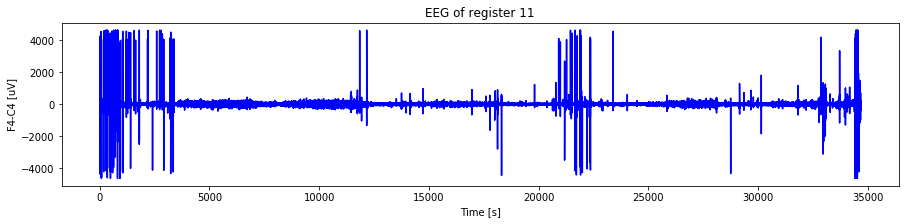

In [40]:
# Show EEG

ind = 10

# Show plot of signal
n_total = signal_list[ind].shape[0]
time_axis = np.arange(0, n_total, 1) / params['fs']
plt.figure(figsize=(15, 3))
plt.plot(time_axis, signal_list[ind], 'b')
plt.xlabel('Time [s]')
plt.ylabel('F4-C4 [uV]')
plt.title('EEG of register {0}'.format(ind+1))
plt.show()

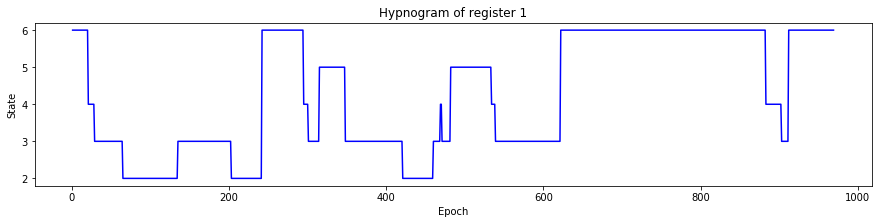

In [41]:
# Show states
ind = 0

n_total = states_list[ind].shape[0]
epoch_axis = np.arange(1, n_total+1, 1)
plt.figure(figsize=(15, 3))
plt.plot(epoch_axis, states_list[ind], 'b')
plt.xlabel('Epoch')
plt.ylabel('State')
plt.title('Hypnogram of register {0}'.format(ind+1))
plt.show()


(2672, 2)  Total marks


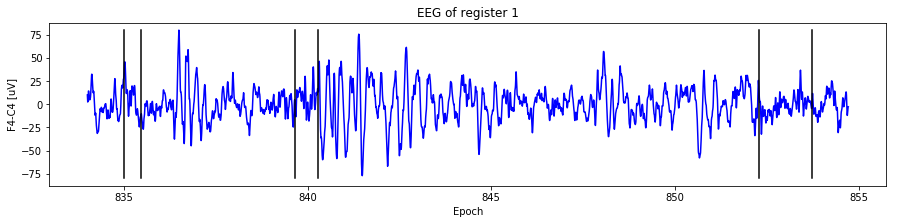

In [44]:
# Show marks

ind = 0
marks_ind = marks_list[ind]
print(marks_ind.shape, " Total marks")

# Let's free the first three marks
from_mark = 0
to_mark = 2
sample_start = marks_ind[from_mark, 0] - params['fs']
sample_end = marks_ind[to_mark, 1] + params['fs']
segment_eeg = signal_list[ind][sample_start:sample_end]

time_axis = np.arange(sample_start, sample_end, 1) / params['fs']

plt.figure(figsize=(15, 3))
plt.plot(time_axis, segment_eeg, 'b')
max_y = max(abs(segment_eeg))
for index in range(from_mark, to_mark+1):
    beg_x = [marks_ind[index, 0] / params['fs'], marks_ind[index, 0] / params['fs']]
    end_x = [marks_ind[index, 1] / params['fs'], marks_ind[index, 1] / params['fs']]
    plt.plot(beg_x, [-max_y, max_y], 'k')
    plt.plot(end_x, [-max_y, max_y], 'k')

plt.xlabel('Epoch')
plt.ylabel('F4-C4 [uV]')
plt.title('EEG of register {0}'.format(ind+1))
plt.show()


In [ ]:
# Extraction of N2 states

n2_val = 3



for ind in range(len(signal_list)):
    states = states_list[ind]
    

# %% Preparing data
# 
# newData = cell(n_reg,1);
# 
# for ind = 1:n_reg
#     states = eegData{ind}.label.states;
#     whole_night = eegData{ind}.eegRecord;
#     n_total = length(whole_night);
#     % N2 segments
#     epochs = (states == n2_val);
#     epochs_inter = seq2inter(epochs);
#     n_segments = size(epochs_inter,1);
#     n2 = cell(n_segments,1);
#     for i = 1:n_segments
#        samples = epoch2timestep(epochs_inter(i,:),set);
#        samples(2) = min(samples(2),n_total);
#        n2{i} = whole_night(samples(1):samples(2)); 
#     end
#     % Find clip value from N2
#     outlier_thr = prctile(abs(cat(1,n2{:})),99);
# 	fprintf('Reg %d outlier thr: %1.4f\n',ind,outlier_thr);
#     % Find mean and std without outliers from N2
#     n2_concat_nan = cat(1,n2{:});
#     n2_concat_nan(abs(n2_concat_nan)>outlier_thr) = nan;
#     n2_mean = nanmean(n2_concat_nan);
#     n2_std = nanstd(n2_concat_nan);
#     % Let's clip and normalize the entire register
#     
#     % Whole Night
#     whole_night_norm = whole_night;
#     whole_night_norm( whole_night>outlier_thr ) = outlier_thr;
# 	whole_night_norm( whole_night<-outlier_thr ) = -outlier_thr;   
#     whole_night_norm = (whole_night_norm - n2_mean) / n2_std;
#     
#     % N2 stages
#     n2_norm = cell(n_segments,1);
#     for i = 1:n_segments
#        n2_norm{i} = n2{i};
#        n2_norm{i}( n2{i}>outlier_thr ) = outlier_thr;
#        n2_norm{i}( n2{i}<-outlier_thr ) = -outlier_thr;   
#        n2_norm{i} = (n2_norm{i} - n2_mean) / n2_std;
#     end
# 
#     newData{ind}.whole_night_norm = whole_night_norm;
#     newData{ind}.n2_norm = n2_norm;
#     newData{ind}.states = states;
#     
# end
# clear whole_night n_total epochs epochs_inter n_segments n2
# clear samples outlier_thr n2_concat_nan n2_mean n2_std
# clear whole_night_norm n2_norm states
# fprintf('Registers and states loaded.\n')


